In [2]:
import nb_utils

Moving cwd to /store/CIA/js2164/repos/diffusion/score_sde_pytorch


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from lightning_modules.BaseSdeGenerativeModel import BaseSdeGenerativeModel
from models.fcn import FCN
from models.ddpm import DDPM
import pickle
import sde_lib

In [24]:
name='real_celebA_crop_ampere_VE_STABLE'
config_path = f'logs/celebA/{name}/config.pkl'
with open(config_path, 'rb') as file:
    config = pickle.load(file)
config.model.checkpoint_path = f'logs/celebA/{name}/checkpoints/best/last.ckpt'

config.device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [25]:
def sample(config):
    from sampling.unconditional import get_sampling_fn
    ckpt_path = config.model.checkpoint_path
    pl_module = BaseSdeGenerativeModel.load_from_checkpoint(ckpt_path)
    pl_module.to(config.device)
    score_model = pl_module.score_model
    pl_module.configure_sde(config)
    pl_module = pl_module.eval()

    num_samples = 10  
    sde = sde_lib.VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales, data_mean=None) #pl_module.sde
    sampling_eps = 1e-5
    sampling_shape = [num_samples] +  config.data.shape
    sampling_fn = get_sampling_fn(config, sde, sampling_shape, sampling_eps)
    score_model = pl_module.score_model
    samples, _ = sampling_fn(score_model)#, show_evolution=False)
    return samples

In [26]:
config.sampling.method = 'pc'
config.sampling.predictor = 'euler_maruyama'
config.sampling.corrector = 'none'
config.sampling.n_steps_each = 1
config.sampling.noise_removal = True
config.sampling.probability_flow = False
config.sampling.snr = 0.1 #0.075
config.model.num_scales=1000

config.model.scale_by_sigma = False

samples = sample(config)

100%|██████████| 1000/1000 [00:58<00:00, 16.96it/s]


In [27]:
samples_normalized = samples
print(samples.min())
print(samples.max())
#samples_normalized = (samples - samples.min())
#samples_normalized = samples_normalized / samples_normalized.max()

tensor(-0.0603, device='cuda:0')
tensor(1.1206, device='cuda:0')


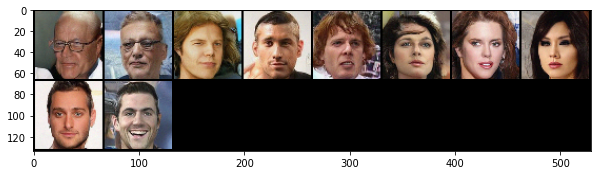

In [28]:
import torchvision
from matplotlib import pyplot as plt
grid_images = torchvision.utils.make_grid(samples_normalized.cpu(), normalize=True, scale_each=True)
plt.figure(figsize=(10,10))
plt.imshow(grid_images.permute(1,2,0))
plt.show()

In [43]:
from lightning_data_modules import HaarDecomposedDataset, ImageDatasets, PairedDataset, SyntheticDataset, SyntheticPairedDataset, Synthetic1DConditionalDataset, SyntheticTimeSeries, SRDataset, SRFLOWDataset, KSphereDataset, MammothDataset, LineDataset, GanDataset #needed for datamodule registration
from dim_reduction import get_manifold_dimension
config.data.base_dir = '/store/CIA/js2164/data'
config.training.batch_size=16
config.model.scale_by_sigma = False
get_manifold_dimension(config)

 50%|█████     | 1/2 [05:57<05:57, 357.32s/it]


In [44]:
path = 'logs/celebA/real_celebA_crop_ampere_VE_STABLE/svd/svd.pkl'
with open(path, 'rb') as f:
    svd = pickle.load(f)
singular_values = svd['singular_values']

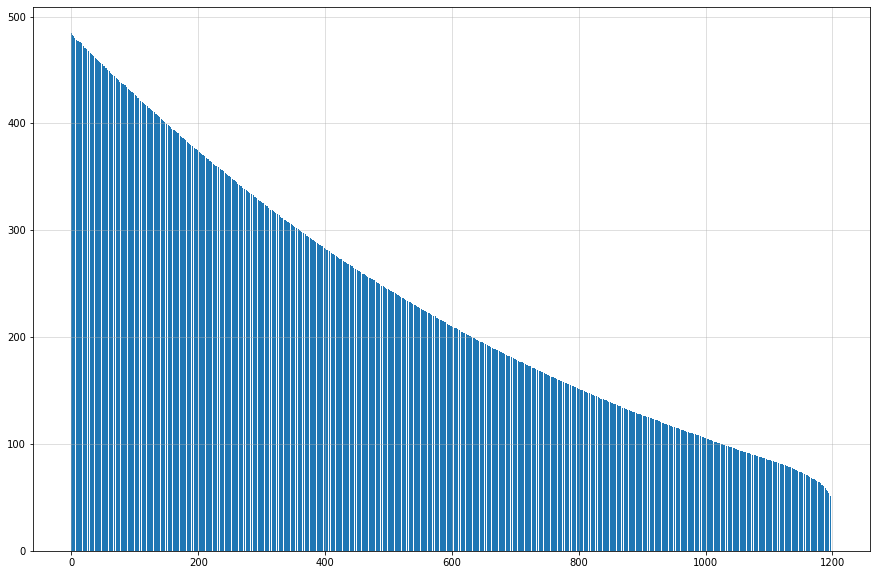

In [45]:
s = singular_values[0][-1200:]
fig = plt.figure(figsize=(15,10))
#ax.rcParams.update({'font.size': 16})
plt.grid(alpha=0.5)
plt.bar(range(len(s)), s)
#plt.xticks(range(0, 100, 5))
#plt.vlines(95, 0, np.max(s), color='r', linestyles='--')
#plt.vlines(70, 0, np.max(s), color='r', linestyles='--')
fig.show()

In [23]:
config.model.progressive_input

'none'